In [1]:
# standart library block
import numpy as np
import pandas as pd
import io
import os
import requests
import seaborn as sns
import statistics
from scipy import stats as sts
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

# learning library block
import statsmodels.formula.api as sm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from catboost import CatBoostClassifier
from catboost.datasets import amazon
from catboost.datasets import epsilon

In [2]:
# Чтение файлов с данными по агрегированным переменным контактов и значению таргета (Reading contracts data file)
countsData = pd.read_csv("Dataset/2_countsData.csv", dtype={'Id': object}, sep=';')
sumData = pd.read_csv("Dataset/3_sumData.csv", dtype={'Id': object}, sep=';')
tipData = pd.read_csv("Dataset/4_tipData.csv", dtype={'Id': object}, sep=';')
targetData = pd.read_csv("Dataset/5_targetData.csv", dtype={'Id': object}, sep=';')

In [3]:
# Объединение файлов в общий массив Dataset_contracts (Joining files into a common dataset Dataset_contracts)
count_sumData = pd.merge(countsData, 
                         sumData, 
                         on = 'Id')
count_sum_tipData = pd.merge(count_sumData,
                            tipData,
                            on = 'Id')
Dataset_contracts = pd.merge(count_sum_tipData,
                            targetData,
                            on = 'Id')

In [4]:
Dataset_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158784 entries, 0 to 158783
Data columns (total 16 columns):
Id                    158784 non-null object
contract_quant        158784 non-null int64
cnt_uniq_buyer        158784 non-null int64
cnt_buyRegion         158784 non-null int64
cnt_buy_contPerson    158784 non-null int64
sku_quant             158784 non-null int64
skuOKPD_quant         158784 non-null int64
cnt_OKEI              158784 non-null int64
personal              158784 non-null int64
cnt_months            158784 non-null int64
tot_contractSum       158784 non-null float64
min_contractSum       158784 non-null float64
max_contractSum       158784 non-null float64
avg_contractSum       158784 non-null float64
bidding_type          158784 non-null int64
soft_target           158784 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 20.6+ MB


C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was de

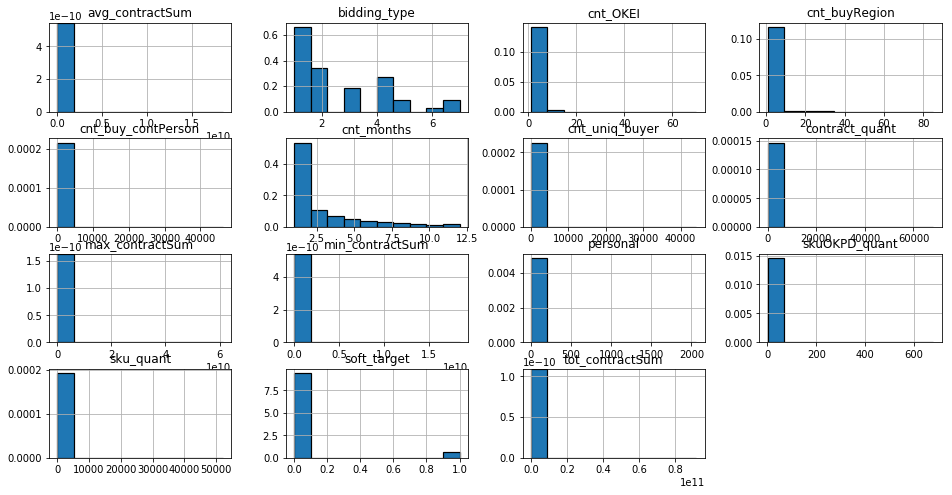

In [5]:
Dataset_contracts.hist(edgecolor='black', linewidth=1.2, normed=True)
fig=plt.gcf()
fig.set_size_inches(16,8)
plt.show()

In [6]:
corr = Dataset_contracts.corr()

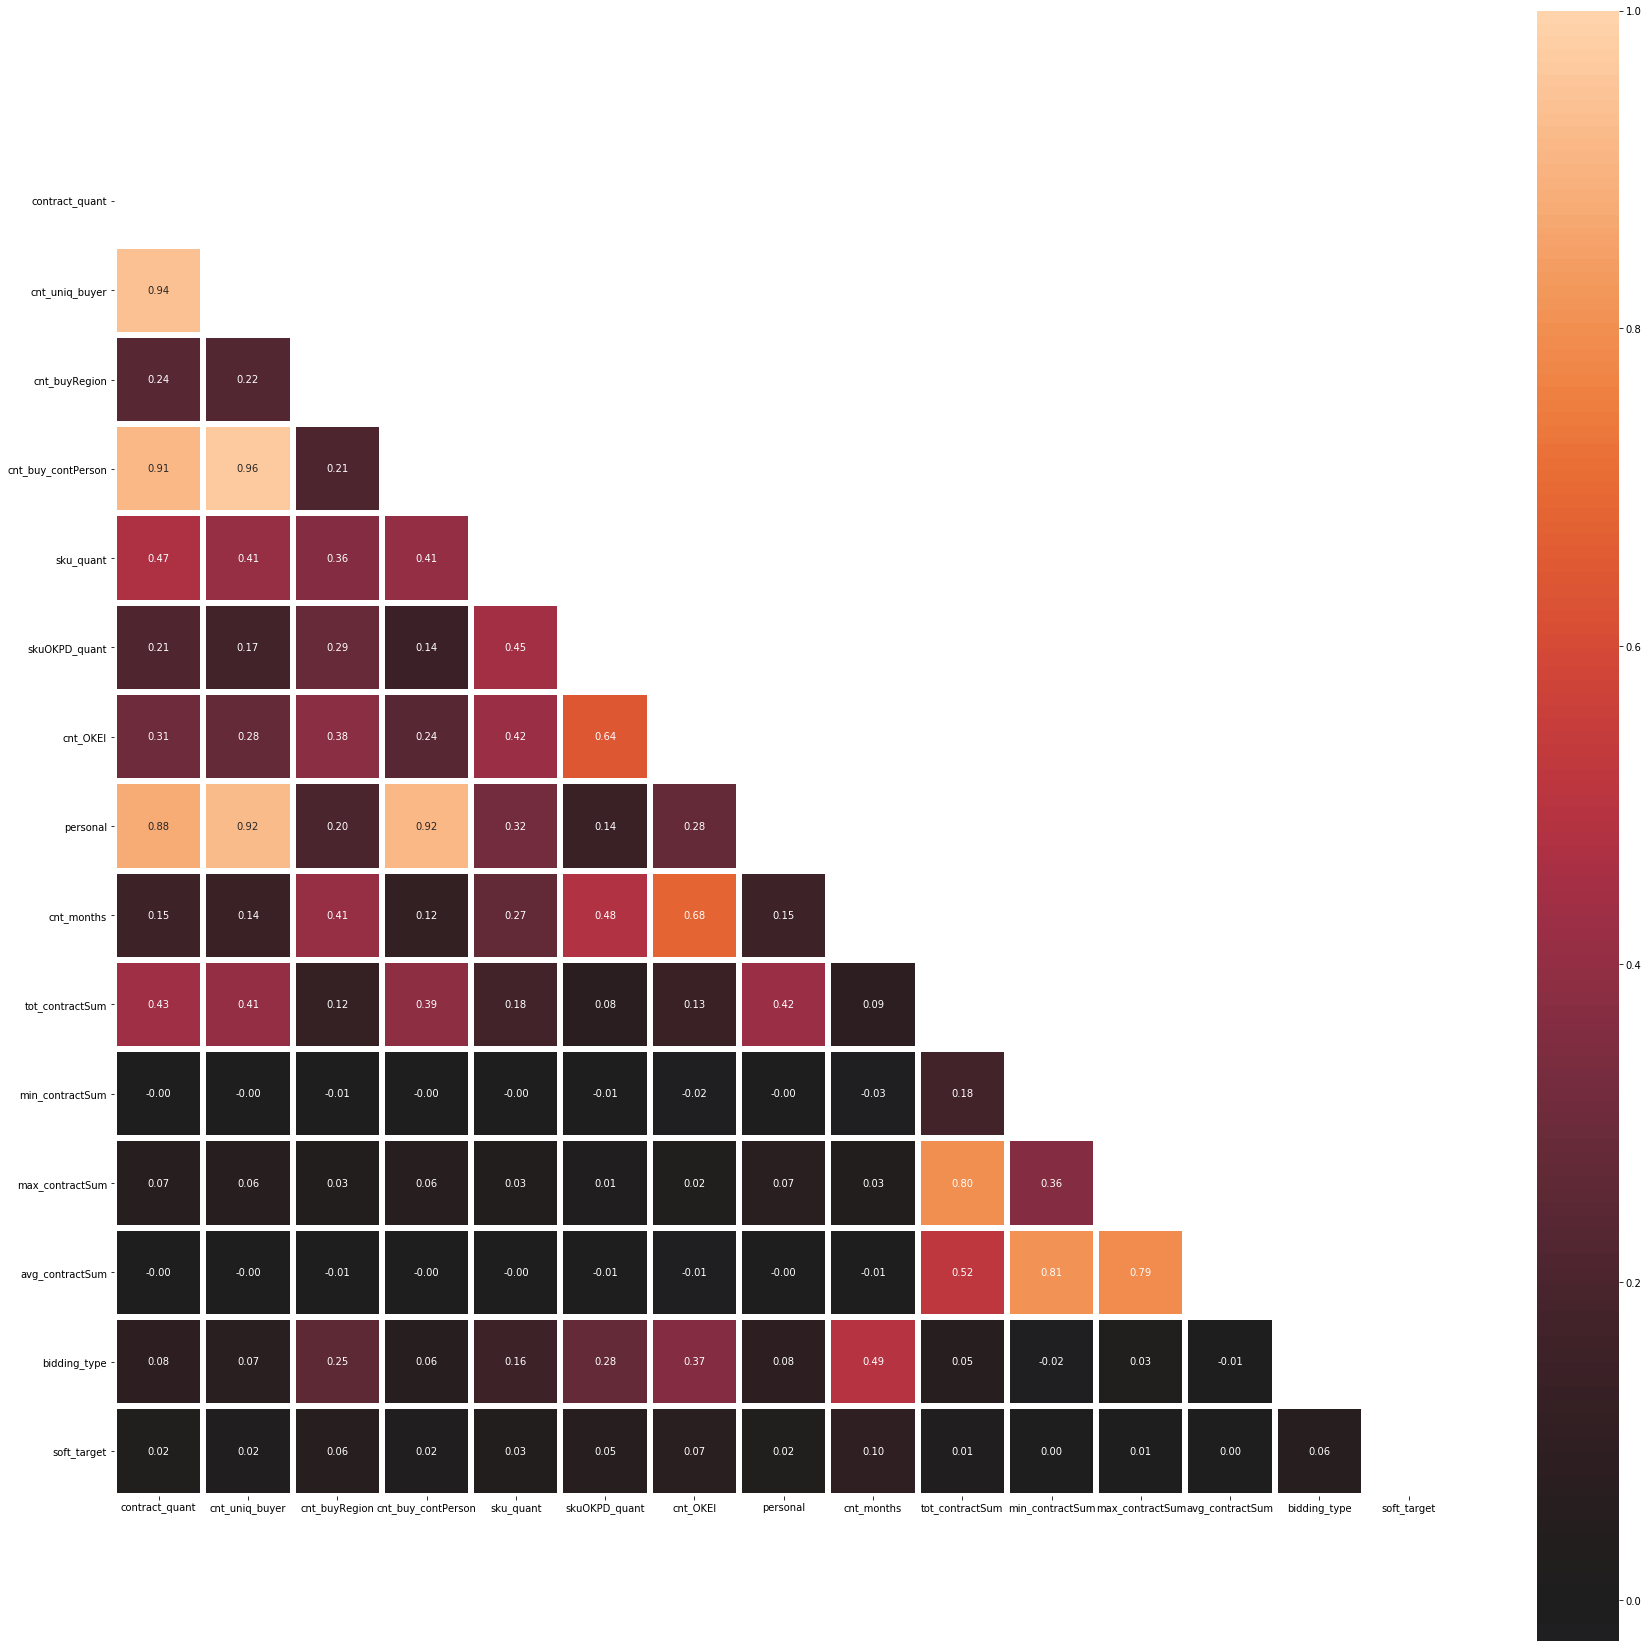

In [7]:
# Визуализация корреляционной матрицы
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(30,30))
# Создание маски для скрытия верхнего треугольника матрицы корреляции
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f', square=True, linewidths=5);

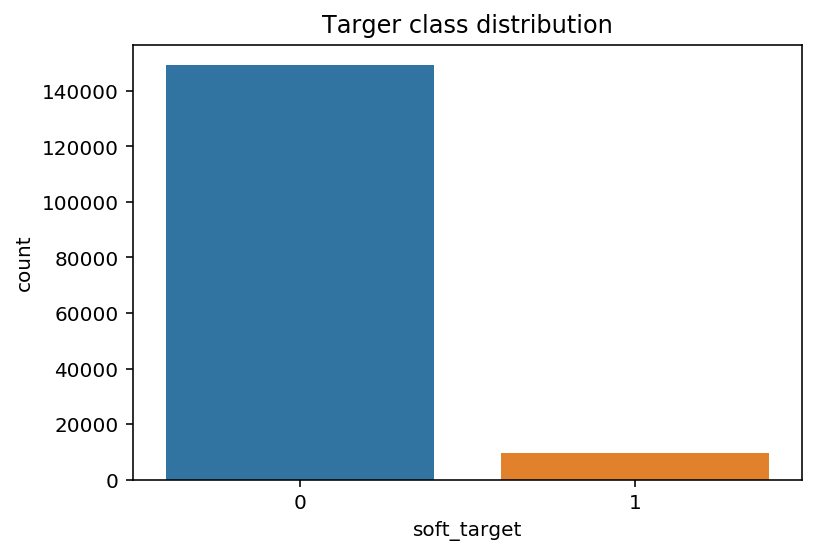

In [8]:
# Распределение значений таргета - параметр 'soft_target'
%config InlineBackend.figure_format = 'retina'
ax = plt.axes()
sns.countplot(x='soft_target', data=Dataset_contracts, ax=ax);
ax.set_title('Targer class distribution')
plt.show()

C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\voropaev.om\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was de

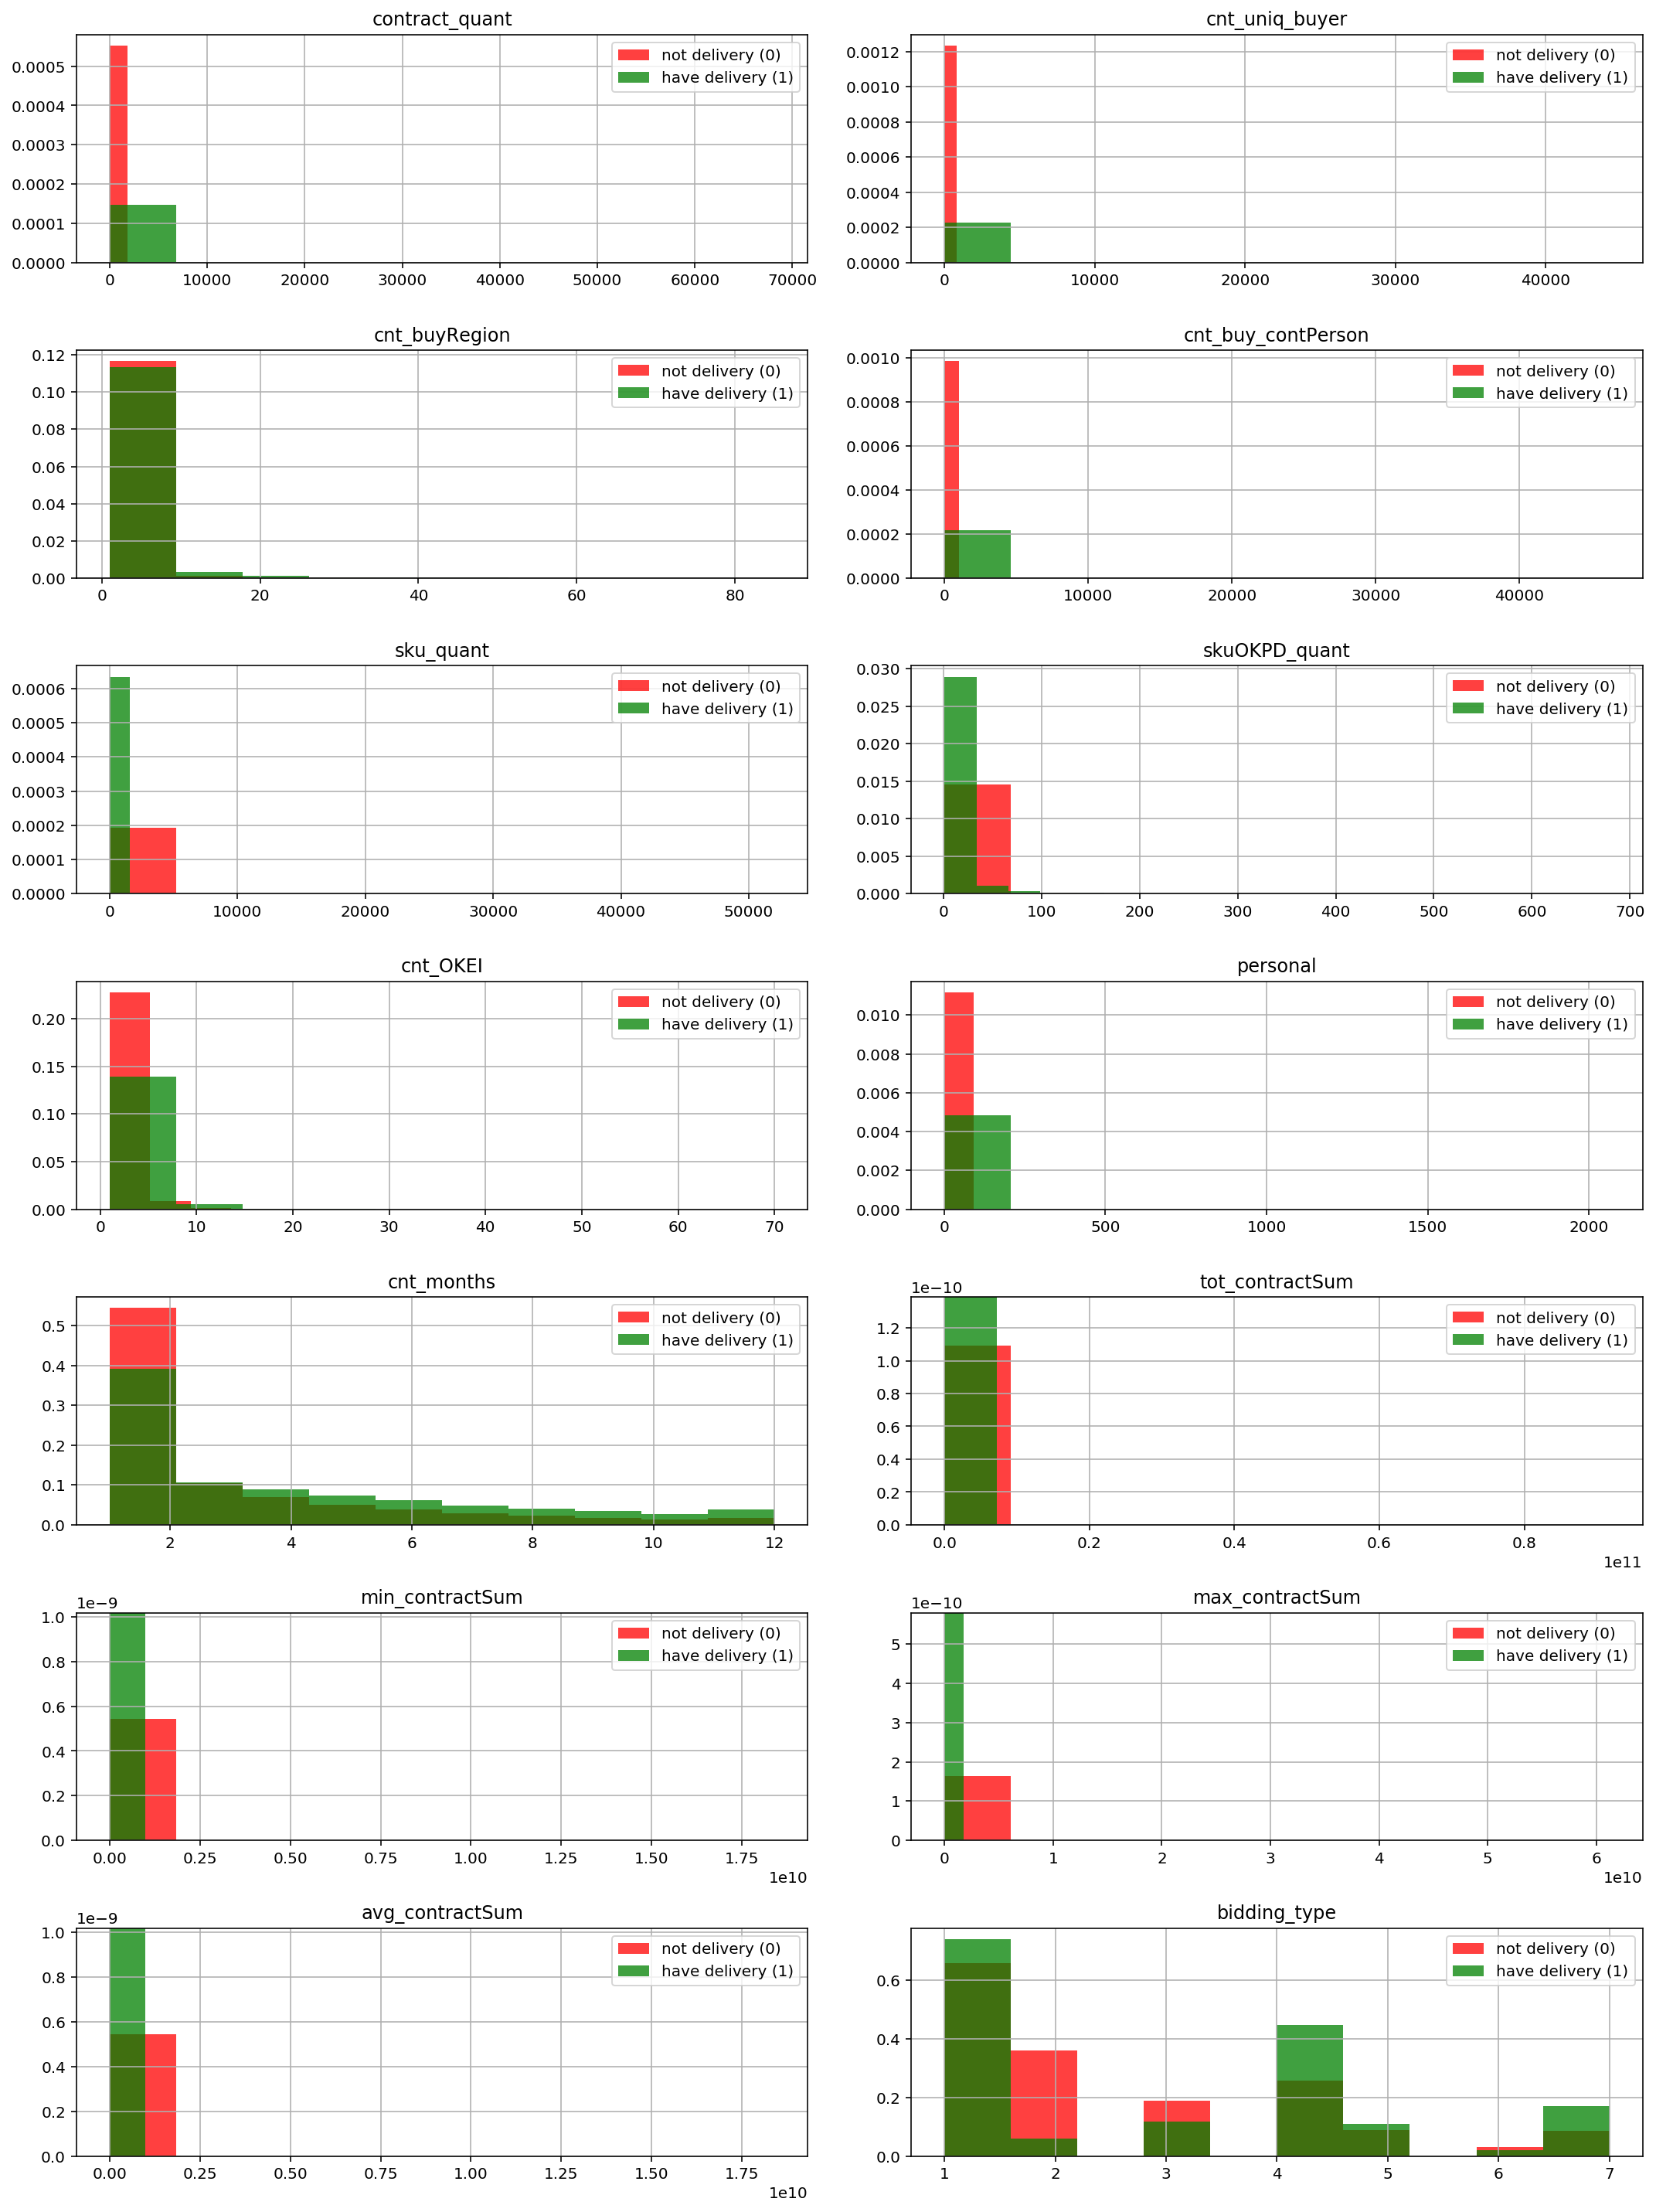

In [11]:
# 'soft_target' совместно 1 и 0.
fig, ax = plt.subplots(7, 2, figsize=(15,20))
for col, axis in zip(Dataset_contracts.select_dtypes(include=[np.number]).columns[0:],[i for i in ax.flat]):
    Dataset_contracts.loc[Dataset_contracts['soft_target']==0, Dataset_contracts.columns!='soft_target'].hist(column=col, ax=axis, alpha=0.75, color='red', label='not delivery (0)', normed=True)
    Dataset_contracts.loc[Dataset_contracts['soft_target']==1, Dataset_contracts.columns!='soft_target'].hist(column=col, ax=axis, alpha=0.75, color='green', label='have delivery (1)', normed=True)
    axis.legend(loc="upper right")
plt.tight_layout()
plt.show();

In [10]:
# Расчет t-критерия для всех переменных группы mean и worst 
#Radius
# значения для mean
contract_quant_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['contract_quant']
contract_quant_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['contract_quant']
# значения для worst
cnt_uniq_buyer_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['cnt_uniq_buyer']
cnt_uniq_buyer_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['cnt_uniq_buyer']
# значения для mean
cnt_buyRegion_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['cnt_buyRegion']
cnt_buyRegion_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['cnt_buyRegion']
# значения для worst
cnt_buy_contPerson_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['cnt_buy_contPerson']
cnt_buy_contPerson_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['cnt_buy_contPerson']
# значения для mean
sku_quant_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['sku_quant']
sku_quant_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['sku_quant']
# значения для worst
cnt_OKEI_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['cnt_OKEI']
cnt_OKEI_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['cnt_OKEI']
# значения для mean
personal_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['personal']
personal_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['personal']
# значения для worst
cnt_months_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['cnt_months']
cnt_months_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['cnt_months']
# значения для mean
tot_contractSum_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['tot_contractSum']
tot_contractSum_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['tot_contractSum']
# значения для worst
min_contractSum_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['min_contractSum']
min_contractSum_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['min_contractSum']
# значения для worst
max_contractSum_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['max_contractSum']
max_contractSum_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['max_contractSum']
# значения для worst
avg_contractSum_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['avg_contractSum']
avg_contractSum_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['avg_contractSum']
# значения для worst
bidding_type_0 = Dataset_contracts[Dataset_contracts['soft_target']==0]['bidding_type']
bidding_type_1 = Dataset_contracts[Dataset_contracts['soft_target']==1]['bidding_type']

# расчет двухвыборочного t-критерия для двух независимых выборок
ttest_contract_quant = sts.ttest_ind(contract_quant_0, contract_quant_1)
ttest_cnt_uniq_buyer = sts.ttest_ind(cnt_uniq_buyer_0, cnt_uniq_buyer_1)
ttest_cnt_buyRegion = sts.ttest_ind(cnt_buyRegion_0, cnt_buyRegion_1)
ttest_cnt_buy_contPerson = sts.ttest_ind(cnt_buy_contPerson_0, cnt_buy_contPerson_1)
ttest_sku_quant = sts.ttest_ind(sku_quant_0, sku_quant_1)
ttest_cnt_OKEI = sts.ttest_ind(cnt_OKEI_0, cnt_OKEI_1)
ttest_personal = sts.ttest_ind(personal_0, personal_1)
ttest_cnt_months = sts.ttest_ind(cnt_months_0, cnt_months_1)
ttest_tot_contractSum = sts.ttest_ind(tot_contractSum_0, tot_contractSum_1)
ttest_min_contractSum = sts.ttest_ind(min_contractSum_0, min_contractSum_1)
ttest_max_contractSum = sts.ttest_ind(max_contractSum_0, max_contractSum_1)
ttest_avg_contractSum = sts.ttest_ind(avg_contractSum_0, avg_contractSum_1)
ttest_bidding_type = sts.ttest_ind(bidding_type_0, bidding_type_1)


# Печать сравнительных результатов t-test
print("Ttest contract_quant: ", ttest_contract_quant)
print("")
print("Ttest cnt_uniq_buyer: ", ttest_cnt_uniq_buyer)
print("")
print("Ttest cnt_buyRegion: ", ttest_cnt_buyRegion)
print("")
print("Ttest cnt_buy_contPerson: ", ttest_cnt_buy_contPerson)
print("")
print("Ttest sku_quant: ", ttest_sku_quant)
print("")
print("Ttest cnt_OKEI: ", ttest_cnt_OKEI)
print("")
print("Ttest personal: ", ttest_personal)
print("")
print("Ttest cnt_months: ", ttest_cnt_months)
print("")
print("Ttest tot_contractSum: ", ttest_tot_contractSum)
print("")
print("Ttest min_contractSum: ", ttest_min_contractSum)
print("")
print("Ttest max_contractSum: ", ttest_max_contractSum)
print("")
print("Ttest avg_contractSum: ", ttest_avg_contractSum)
print("")
print("Ttest bidding_type: ", ttest_bidding_type)


Ttest contract_quant:  Ttest_indResult(statistic=-7.236787499394099, pvalue=4.615004878413714e-13)

Ttest cnt_uniq_buyer:  Ttest_indResult(statistic=-6.927656811943587, pvalue=4.294866252485654e-12)

Ttest cnt_buyRegion:  Ttest_indResult(statistic=-24.017025181826522, pvalue=3.1195342436009588e-127)

Ttest cnt_buy_contPerson:  Ttest_indResult(statistic=-6.408899464603731, pvalue=1.4698240675119686e-10)

Ttest sku_quant:  Ttest_indResult(statistic=-10.563616890008834, pvalue=4.482505312646334e-26)

Ttest cnt_OKEI:  Ttest_indResult(statistic=-27.562705532642237, pvalue=7.729034764071409e-167)

Ttest personal:  Ttest_indResult(statistic=-9.384631986905934, pvalue=6.392966597446803e-21)

Ttest cnt_months:  Ttest_indResult(statistic=-39.05702563573268, pvalue=0.0)

Ttest tot_contractSum:  Ttest_indResult(statistic=-4.862799346806042, pvalue=1.1584757703268956e-06)

Ttest min_contractSum:  Ttest_indResult(statistic=-0.9355123955872074, pvalue=0.3495257210061068)

Ttest max_contractSum:  Ttes

###### Комментарий 
Отличия в распределении выборок (с таргетом 1 и 0) наблюдаются практически во всех переменных. За исключением двух независимых выборок (fractal_dimension_mean, со значением ***target*** 1 и 0, где значение p-value=0.75) все остальные выборки имеют значение p-value намного меньше 0.05, поэтому мы отвергаем нулевую гипотезу и можем сказать, что имеется статистическое различие между выборками по всеми переменными в зависимости от значения ***target***.

Следует также отметить, что в большинстве переменных группы ***worst*** значение p-value гораздо меньше, чем в их аналогах в группе ***mean***. Данное обстоятельство, предположительно, указывает на то, что статистическое различия между аналогичными выборками в группе ***worst*** гораздо сильнее, чем в группе ***mean***.